# Using the Spotify API

*This project uses the Spotify API to gather artist data to practice data analysis. The artist I chose is Red Hot Chili Peppers (RHCP) as they have been around for a long time and have a very diverse back catalogue. I enjoyed everything they released up to and including their album "By the Way" - after this, I haven't enjoyed their new releases quite as much. I want to find out if there are any trends in the features of their music over time, or if there is any quantitative reason that explains why "By the Way" is the last album that I really enjoyed...*

### Step 1 - Authentication

Import relevant libraries.

In [1]:
import requests

Client ID and secret from Spotify Web App.

In [2]:
CLIENT_ID = '8a37594c4d9747a7830686f0c865cc1e'
CLIENT_SECRET = 'c538df5ac2a1490bb7e50da2aa8c0c77'

POST request for access token.

In [3]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# Convert the response to JSON
auth_response_data = auth_response.json()

# Save the access token
access_token = auth_response_data['access_token']

### Step 2 - Accessing and Cleaning Data

Import relevant libraries.

In [29]:
import pandas as pd
import datetime
from urllib.parse import urlencode

Set query parameters.

In [4]:
endpoint = "https://api.spotify.com/v1"
RHCP_id = "0L8ExT028jH3ddEcZwqJJ5"
headers = {"Authorization": f"Bearer {access_token}"}

GET request for general information about the band.

In [5]:
r = requests.get(endpoint + "/artists/" + RHCP_id, headers=headers)
r.json()

{'external_urls': {'spotify': 'https://open.spotify.com/artist/0L8ExT028jH3ddEcZwqJJ5'},
 'followers': {'href': None, 'total': 19175195},
 'genres': ['alternative rock', 'funk metal', 'funk rock', 'permanent wave'],
 'href': 'https://api.spotify.com/v1/artists/0L8ExT028jH3ddEcZwqJJ5',
 'id': '0L8ExT028jH3ddEcZwqJJ5',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5ebc33cc15260b767ddec982ce8',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174c33cc15260b767ddec982ce8',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178c33cc15260b767ddec982ce8',
   'width': 160}],
 'name': 'Red Hot Chili Peppers',
 'popularity': 84,
 'type': 'artist',
 'uri': 'spotify:artist:0L8ExT028jH3ddEcZwqJJ5'}

To perform some more in-depth analysis, I want to build a Data Frame with all of the band's tracks they have released on Spotify. Firstly, I'll need to make a new GET request for the tracks data. *[NOTE: I will omit any tracks that are not available outside of the UK (country code: GB) and those that were released as a single / on compilations / appears on albums.]*

In [6]:
# Query parameters to search only albums released in the UK (GB) and increase reponse to 50
params = urlencode({"include_groups": "album", "market": "GB", "limit": 50})

# GET
r_albums = requests.get(endpoint + "/artists/" + RHCP_id + "/albums", headers=headers, params=params)

# Save data as json
data = r_albums.json()

Here is a list of all of the albums and their release dates within the search parameters.

In [7]:
for album in data['items']:
    print(album['name'], ' --- ', album['release_date'])

Return of the Dream Canteen  ---  2022-10-14
Unlimited Love  ---  2022-04-01
The Getaway  ---  2016-06-17
I'm with You  ---  2011-08-29
Stadium Arcadium  ---  2006-05-09
By the Way  ---  2002-07-09
By the Way (Deluxe Edition)  ---  2002-07-09
Californication  ---  1999-06-08
Californication (Deluxe Edition)  ---  1999-06-08
One Hot Minute (Deluxe Edition)  ---  1995-09-12
One Hot Minute  ---  1995-09-12
Blood Sugar Sex Magik (Deluxe Edition)  ---  1991-09-24
Mother's Milk  ---  1989-08-16
The Uplift Mofo Party Plan  ---  1987
Freaky Styley  ---  1985-08-16
Red Hot Chili Peppers  ---  1984-08-10


A few of the studio albums have Deluxe Editions so I need to ensure there are no duplicate tracks in my data set. As Deluxe Edition albums contain all of the original album's tracks plus bonus tracks, I should omit any original albums that have a Deluxe Edition from my data.

In [8]:
# Albums with duplicates removed
albums = []

# Trim out duplicate albums
for album in data['items']: # Iterate through each album in data
    album_name = album['name'] # Set album's full name
    trim_name = album_name.split('(')[0].strip() # Set album's trimmed name
    if any(trim_name in i for i in albums): # Check if trimmed name appears as substring in list
        if "(Deluxe Edition)" in album_name:
            albums = list(map(lambda x: x.replace(trim_name, album_name), albums)) # Replace original with deluxe edition
        else:
            continue
    else:
        albums.append(album_name) # Add album name to list if not already present

albums # Checking subset of albums

['Return of the Dream Canteen',
 'Unlimited Love',
 'The Getaway',
 "I'm with You",
 'Stadium Arcadium',
 'By the Way (Deluxe Edition)',
 'Californication (Deluxe Edition)',
 'One Hot Minute (Deluxe Edition)',
 'Blood Sugar Sex Magik (Deluxe Edition)',
 "Mother's Milk",
 'The Uplift Mofo Party Plan',
 'Freaky Styley',
 'Red Hot Chili Peppers']

Next, I can obtain the track data from the reduced album list.

In [9]:
# Track data
track_data = []

# Loop over albums and get all tracks
for album in data['items']:
    album_name = album['name']

    # Only get tracks from the non-duplicate albums list
    if album_name not in albums:
        continue
    else:
        # Print album name to check progress 
        print(album_name)
    
        # GET all tracks from current album
        r2 = requests.get(endpoint + '/albums/' + album['id'] + '/tracks', 
            headers=headers)
        tracks = r2.json()['items']
    
        for track in tracks:

            # GET track audio-features
            features = requests.get(endpoint + '/audio-features/' + track['id'], 
                headers=headers)
            features = features.json()
        
            # Combine with album info
            features.update({
                'track_name': track['name'],
                'album_name': album_name,
                'short_album_name': trim_name,
                'release_date': album['release_date'],
                'album_id': album['id']
            })
        
            track_data.append(features)

Return of the Dream Canteen
Unlimited Love
The Getaway
I'm with You
Stadium Arcadium
By the Way (Deluxe Edition)
Californication (Deluxe Edition)
One Hot Minute (Deluxe Edition)
Blood Sugar Sex Magik (Deluxe Edition)
Mother's Milk
The Uplift Mofo Party Plan
Freaky Styley
Red Hot Chili Peppers


Store subset of albums from data as a Pandas DataFrame.

In [10]:
df = pd.DataFrame(track_data)

Use datetime to standardise the dates and sort tracks by release date.

In [11]:
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

### Step 3 - Data Cleaning and Wrangling

The next step here is to have a brief look at the new DataFrame and prepare the data for analysis.

In [12]:
# Information about df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 216 to 0
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   danceability      217 non-null    float64       
 1   energy            217 non-null    float64       
 2   key               217 non-null    int64         
 3   loudness          217 non-null    float64       
 4   mode              217 non-null    int64         
 5   speechiness       217 non-null    float64       
 6   acousticness      217 non-null    float64       
 7   instrumentalness  217 non-null    float64       
 8   liveness          217 non-null    float64       
 9   valence           217 non-null    float64       
 10  tempo             217 non-null    float64       
 11  type              217 non-null    object        
 12  id                217 non-null    object        
 13  uri               217 non-null    object        
 14  track_href        217 non-

In [13]:
# Overview of all column headings
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'short_album_name',
       'release_date', 'album_id'],
      dtype='object')

In [14]:
# Quick look at statistical data
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,0.554161,0.807484,5.506912,-5.632484,0.539171,0.074989,0.077007,0.073470,0.177301,0.511584,117.971558,241166.188940,3.917051
std,0.139798,0.182263,3.723200,3.143433,0.499616,0.050406,0.164685,0.195869,0.130531,0.230857,27.044314,79255.689149,0.443612
min,0.000000,0.111000,0.000000,-19.176000,0.000000,0.000000,0.000014,0.000000,0.021600,0.000000,0.000000,14533.000000,0.000000
25%,0.471000,0.717000,2.000000,-6.688000,0.000000,0.039800,0.002950,0.000010,0.094000,0.323000,97.743000,205733.000000,4.000000
50%,0.567000,0.870000,6.000000,-5.071000,1.000000,0.059500,0.014900,0.000372,0.124000,0.506000,113.474000,239640.000000,4.000000
75%,0.652000,0.951000,9.000000,-3.545000,1.000000,0.097600,0.066700,0.017300,0.226000,0.708000,133.433000,271933.000000,4.000000
max,0.939000,0.998000,11.000000,-0.320000,1.000000,0.342000,0.944000,0.992000,0.903000,0.964000,204.026000,776200.000000,5.000000


From a brief look at the statistical data, several of the audio features have a minimum value of 0: danceability, key, mode, speechiness, instrumentalness, valence, tempo, time_signature. For key, the value can be any integer from 0 to 11 with 0 corresponding with the track being played in the key of 'C' so I can ignore this. For mode, the value can be either 0 or 1 with 0 corresponding with the track being played in a minor key so I can ignore this. Instrumentalness can have any real number between 0 and 1 with 0 representing 100% confidence that the track contains vocals and 1 that its purely instrumental. As it is reasonable for the instrumentalness to be 0, I will also ignore this. The other audio features can have any real value from 0 to some limit, so I need to check if they should be removed from the DataFrame.

In [15]:
# Check how many 0 values in each column
df.isin([0]).sum(axis=0)

danceability          1
energy                0
key                  31
loudness              0
mode                100
speechiness           1
acousticness          0
instrumentalness     25
liveness              0
valence               1
tempo                 1
type                  0
id                    0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        1
track_name            0
album_name            0
short_album_name      0
release_date          0
album_id              0
dtype: int64

There is only 1 track that has a 0 value for danceability, speechiness, valence, tempo and time_signature. I will check to see if it is the same track.

In [16]:
# Locating row with danceablity value 0
df.loc[df['danceability'] == 0]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id
195,0.0,0.455,10,-17.536,1,0.0,0.555,0.0,0.37,0.0,...,spotify:track:2kWX2aZ7KWBpJqrCFLphOl,https://api.spotify.com/v1/tracks/2kWX2aZ7KWBp...,https://api.spotify.com/v1/audio-analysis/2kWX...,14533,0,Thirty Dirty Birds - Remastered,Freaky Styley,Red Hot Chili Peppers,1985-08-16,10Oqhoq2akSJnurJOPk8xT


I can see that row 195, track name: *"Thirty Dirty Birds - Remastered"*, has 0 values for danceability, speechiness, valence, tempo and time_signature. As I know this track is spoken word, I can see that a value of 0 for speechiness doesn't make sense so I will remove it from the DataFrame.

In [17]:
# Remove row 195 from dataframe
df = df.drop(df[df['danceability'] == 0].index)

Some of the column headings are not useful for further analysis so they can be removed.

In [18]:
df = df.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'short_album_name', 'album_id'])

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_name,album_name,release_date
216,0.658,0.598,2,-12.971,1,0.1840,0.74700,0.144000,0.1430,0.875,109.663,237867,What It Is (AKA Nina's Song) - Demo Version,Red Hot Chili Peppers,1984-08-10
201,0.641,0.899,11,-4.992,0,0.0787,0.04070,0.000001,0.1180,0.562,110.745,220400,True Men Don't Kill Coyotes - 2002 Digital Rem...,Red Hot Chili Peppers,1984-08-10
202,0.738,0.931,4,-4.675,0,0.1080,0.02500,0.000000,0.0658,0.692,90.610,220827,Baby Appeal - 2002 Digital Remaster,Red Hot Chili Peppers,1984-08-10
203,0.672,0.921,0,-5.648,1,0.0723,0.00434,0.000074,0.2870,0.361,110.921,204267,Buckle Down - 2002 Digital Remaster,Red Hot Chili Peppers,1984-08-10
204,0.652,0.968,2,-5.339,1,0.1010,0.00773,0.000844,0.1870,0.191,129.569,173400,Get Up And Jump - 2002 Digital Remaster,Red Hot Chili Peppers,1984-08-10


### Step 4 - Analysis

Now that the data is in a useable format, I will investigate any correlations between audio features. I am particularly interested to see if there is any correlation between specific audio features and date released to explain why I prefer their older music!

Import relevant libraries.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Before diving deeper, a correlation matrix will allow me to quickly check any interesting relationships.

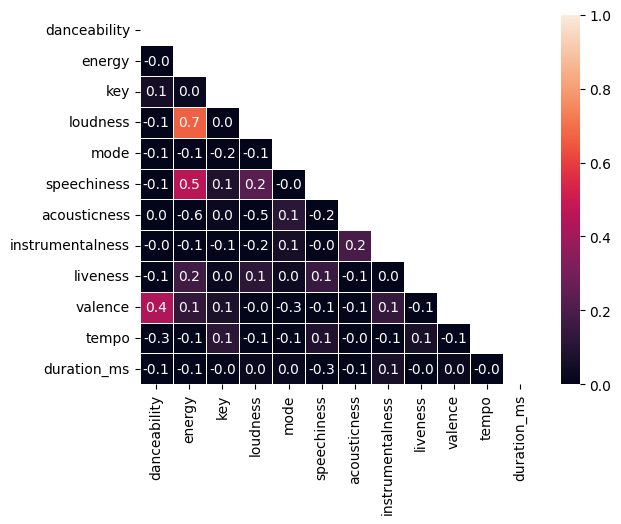

In [21]:
corr_matrix = df.corr(numeric_only=True)
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".1f", linewidth=.5, vmin=0, vmax=1)
plt.show()

Not much insight is gained from the correlation matrix that isn't obvious: loudness correlates strongly with energy (a perceptual measure of intensity and activity); and valence (a measure of the musical positiveness) correlates weakly with danceability. However, one interesting relationship is between speechiness (a measure of the amount of spoken word) and energy. This would indicate that the tracks for which the vocalist (Anthony Kiedis) spends a lot of time on the mic tend to feel more fast, loud, and noisy.

Now I'm going to see how the tracks have developed over time to see if there is a reason for me preferring their earlier music. Firstly, I'll see how the energy and valence of their music has developed.

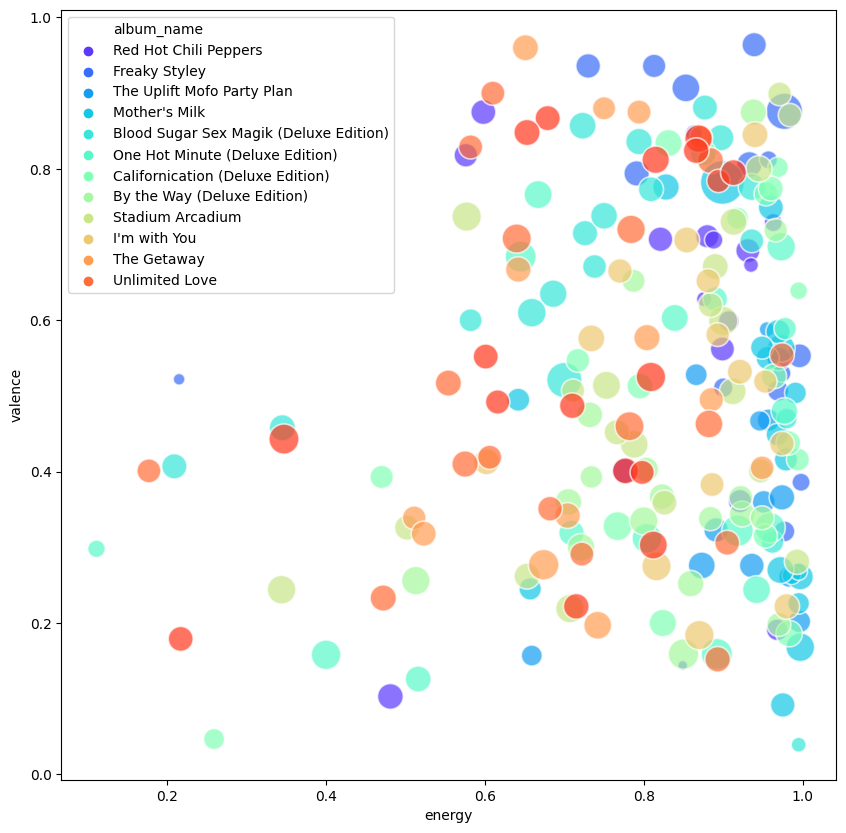

In [22]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df, x='energy', y='valence', 
                     hue='album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# Display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[0:13], labs[0:13], loc='best', title=None)

Based on the scatterplot above, it is unsurprising for me to see that the band's backcatalogue is mostly energetic. However, I note that there is a large spread of values for valency. So although they have been relatively consistent in their energy, they have managed to convey a range of emotions through their music. When comparing the earlier music (*"Red Hot Chili Peppers", "Freaky Styley", "The Uplift Mofo Party Plan"*) with their more recent releases (*"I'm With You", "The Getaway", "Unlimited Love*), the data does suggest there the first 2/3 albums in particular were very energetic and upbeat whereas the most recent albums have been more diverse. As a listener, this does match up with what I've found. I particularly enjoy listening to their upbeat songs - which would go some way to explaining why I prefer the earlier albums. From this graph, I get a look at how individual tracks compare but it's difficult to compare each album. Next, I'll create a new DataFrame with track data averaged for each album to see if there are any trends over time.

In [23]:
# DF to show how audio features have changed from album to album
df_albums = df.groupby(['release_date', 'album_name'], as_index=False)['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'].mean()

df_albums

/var/folders/7c/2jln1g7j1xs_gsnhpshxqzzw0000gp/T/ipykernel_14206/2684191511.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_albums = df.groupby(['release_date', 'album_name'], as_index=False)['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',


,release_date,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1984-08-10,Red Hot Chili Peppers,0.631000,0.829313,5.625000,-7.240375,0.687500,0.103987,0.131046,0.157902,0.148169,0.556250,110.447312,172460.062500
1,1985-08-16,Freaky Styley,0.669941,0.873824,4.882353,-5.929000,0.411765,0.080741,0.105202,0.184906,0.206947,0.691588,112.924118,198072.176471
2,1987-01-01,The Uplift Mofo Party Plan,0.601333,0.915583,5.333333,-4.021500,0.583333,0.126292,0.015572,0.000416,0.172850,0.356000,111.339500,192096.750000
3,1989-08-16,Mother's Milk,0.467632,0.930947,6.263158,-4.171000,0.578947,0.117442,0.031708,0.162138,0.276784,0.432937,124.285789,246078.578947
4,1991-09-24,Blood Sugar Sex Magik (Deluxe Edition),0.576737,0.752842,5.526316,-10.754579,0.684211,0.062163,0.013822,0.106861,0.172521,0.623168,121.035368,252251.157895
5,1995-09-12,One Hot Minute (Deluxe Edition),0.496563,0.763750,5.062500,-5.720125,0.812500,0.067962,0.093034,0.040333,0.192206,0.419438,114.168813,295650.125000
6,1999-06-08,Californication (Deluxe Edition),0.483167,0.845000,3.388889,-3.221778,0.388889,0.096317,0.058438,0.125763,0.132706,0.515594,115.152333,226422.500000
7,2002-07-09,By the Way (Deluxe Edition),0.522833,0.826667,6.111111,-3.970167,0.555556,0.060567,0.051219,0.000690,0.186006,0.396167,120.965389,255129.611111
8,2006-05-09,Stadium Arcadium,0.540750,0.798300,5.200000,-4.006050,0.600000,0.050970,0.064394,0.007105,0.165355,0.521700,117.647400,266257.950000
9,2011-08-29,I'm with You,0.561071,0.862429,5.642857,-3.188714,0.285714,0.056214,0.051592,0.001078,0.187814,0.499286,120.094143,254535.214286


In [24]:
# Adding an album release number column
df_albums.insert(0, 'release_number', range(1, 1 + len(df_albums)))

df_albums

,release_number,release_date,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1,1984-08-10,Red Hot Chili Peppers,0.631000,0.829313,5.625000,-7.240375,0.687500,0.103987,0.131046,0.157902,0.148169,0.556250,110.447312,172460.062500
1,2,1985-08-16,Freaky Styley,0.669941,0.873824,4.882353,-5.929000,0.411765,0.080741,0.105202,0.184906,0.206947,0.691588,112.924118,198072.176471
2,3,1987-01-01,The Uplift Mofo Party Plan,0.601333,0.915583,5.333333,-4.021500,0.583333,0.126292,0.015572,0.000416,0.172850,0.356000,111.339500,192096.750000
3,4,1989-08-16,Mother's Milk,0.467632,0.930947,6.263158,-4.171000,0.578947,0.117442,0.031708,0.162138,0.276784,0.432937,124.285789,246078.578947
4,5,1991-09-24,Blood Sugar Sex Magik (Deluxe Edition),0.576737,0.752842,5.526316,-10.754579,0.684211,0.062163,0.013822,0.106861,0.172521,0.623168,121.035368,252251.157895
5,6,1995-09-12,One Hot Minute (Deluxe Edition),0.496563,0.763750,5.062500,-5.720125,0.812500,0.067962,0.093034,0.040333,0.192206,0.419438,114.168813,295650.125000
6,7,1999-06-08,Californication (Deluxe Edition),0.483167,0.845000,3.388889,-3.221778,0.388889,0.096317,0.058438,0.125763,0.132706,0.515594,115.152333,226422.500000
7,8,2002-07-09,By the Way (Deluxe Edition),0.522833,0.826667,6.111111,-3.970167,0.555556,0.060567,0.051219,0.000690,0.186006,0.396167,120.965389,255129.611111
8,9,2006-05-09,Stadium Arcadium,0.540750,0.798300,5.200000,-4.006050,0.600000,0.050970,0.064394,0.007105,0.165355,0.521700,117.647400,266257.950000
9,10,2011-08-29,I'm with You,0.561071,0.862429,5.642857,-3.188714,0.285714,0.056214,0.051592,0.001078,0.187814,0.499286,120.094143,254535.214286


Again, I will use a correlation matrix to check for any trends.

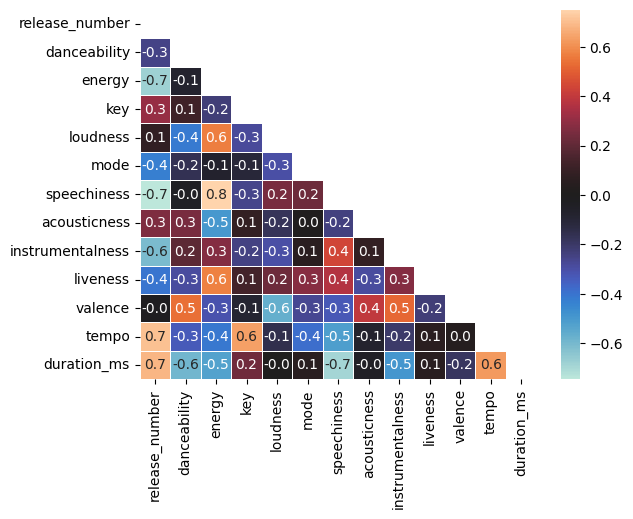

In [25]:
corr_matrix_albums = df_albums.corr(numeric_only=True)
mask_albums = np.triu(corr_matrix_albums)
sns.heatmap(corr_matrix_albums, mask=mask_albums, annot=True, fmt=".1f", linewidth=.5, center=0)
plt.show()

Interestingly, there are a few relationships that occur with the album release number. Both energy and speechiness have a strong negative correlation with album number, whereas tempo and duration have a strong positive correlation with album number.

A good way to visualise this data would be to use seaborn's pairplot function. I will compare only those features with a strong correlation (coeff >= 0.7).

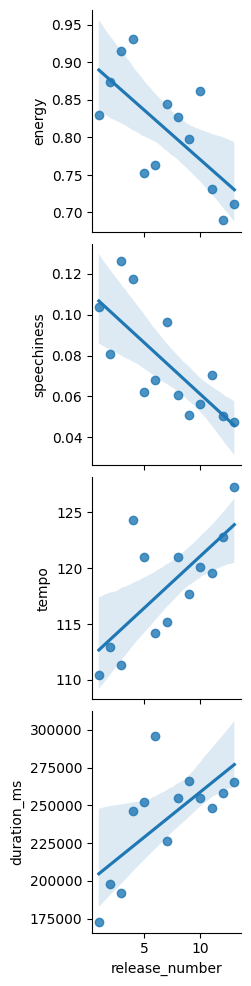

In [28]:
sns.pairplot(df_albums, x_vars='release_number', y_vars=['energy', 'speechiness', 'tempo', 'duration_ms'], kind='reg')

From the results above, I can see firstly that the RHCP have become less energetic over time. This is probably to be expected for a band that has been around for so long as their members grow older and lose a bit of their liveliness from the early days. Also, I notice that their tracks tend to have less spoken word on more recent albums. As someone who has followed the band throughout their career this matches up with my own observations. Their early music was focused around beat poetry and funky rhythms but their more recent work has a much more melodic feel. Incidentally, both the tempo and song duration have increased over time. It's surprising to note that the tempo has decreased because their earlier tracks actually feel faster - perhaps this is because they used to include more syncopated rhythms and raucous basslines. Also, it is counterintuitive that the songs have become quicker in pace but longer in duration. It seems that their new style of writing longer but faster tracks has come at the cost of their raw energy they had when they made a name for themselves.

For the final part of the analysis, I would like to see if there is a quantitative difference between the music up to and including *"By the Way"*, and everything released afterwards. This arbitrary point in time is when I personally stopped enjoying their new releases as much. As such, the results are not to be taken too seriously - it's just a bit of fun! I'm interested to find which of the features in this analysis changed the most after that album. To do this, I need to write a function that shows both a scatterplot with trendlines shown before and after the realease of *"By the Way"*, and the percentage change in the gradients of these trendlines. The bigger the percentage change, the bigger the difference in a given trend.

In [133]:
def before_and_after_btw(feature):
    
    # Set x and y to appropriate data
    x = df_albums['release_number']
    y = df_albums[feature]

    # Define the ranges for the lines of best fit - "By the Way" is the band's 8th studio release
    x1 = x[:8]
    x2 = x[8:]
    y1 = y[:8]
    y2 = y[8:]

    # Calculate the lines of best fit using linear regression
    m1, b1 = np.polyfit(x1, y1, 1)
    m2, b2 = np.polyfit(x2, y2, 1)

    # Create the plot
    plt.plot(x, y, 'bo', label='Albums')
    plt.plot(x1, m1*x1 + b1, 'r-', label='Pre-BTW')
    plt.plot(x2, m2*x2 + b2, 'g-', label='Post-BTW')
    plt.axvline(x=8, color='c', label='BTW')
    plt.xlabel("Release Number")
    plt.ylabel(feature)
    plt.title(f"How {feature} in RHCP Albums Varies Before and After By the Way")
    plt.legend()
    plt.show()
    
    # Change in gradient
    grad_change = abs((m2-m1)/m1)*100
    print(f"Percentage change in gradient: {round(grad_change, 1)}%")

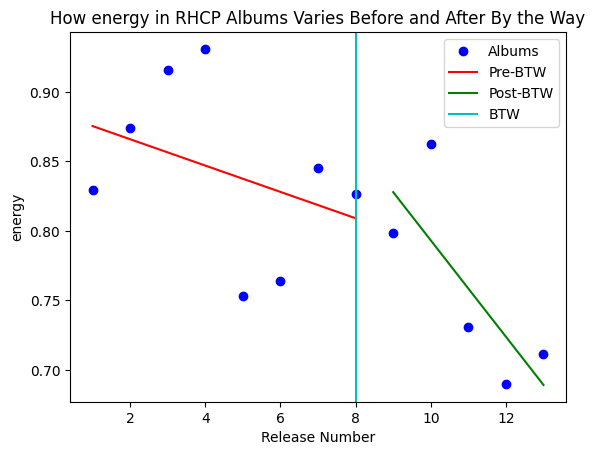

Percentage change in gradient: 266.0%


In [129]:
before_and_after_btw('energy')

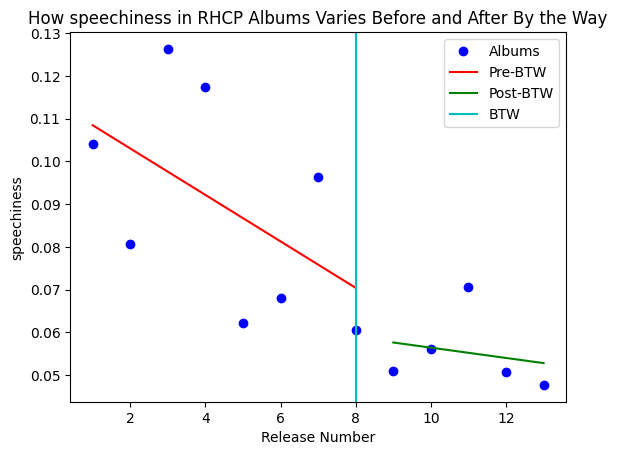

Percentage change in gradient: 77.8%


In [130]:
before_and_after_btw('speechiness')

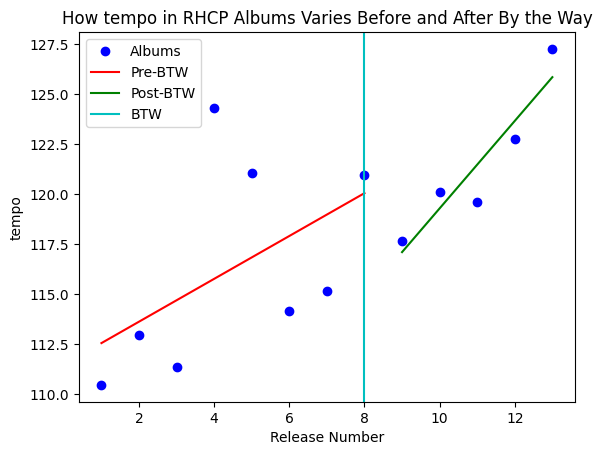

Percentage change in gradient: 104.2%


In [131]:
before_and_after_btw('tempo')

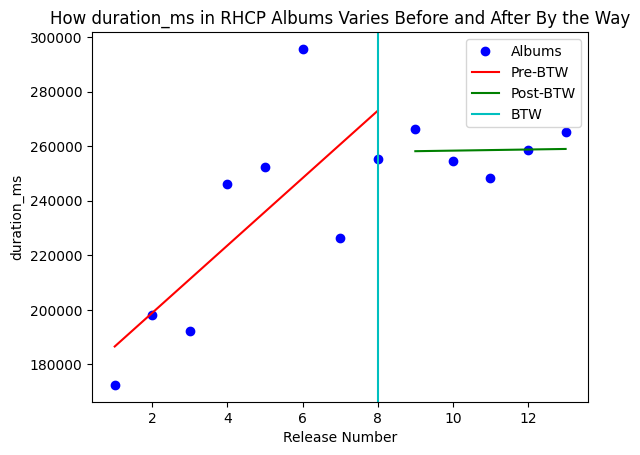

Percentage change in gradient: 98.3%


In [132]:
before_and_after_btw('duration_ms')

From the above graphs there are 4 observations. Firstly, the energy of the songs after *"By the Way"* dropped at a faster rate than they were dropping before it was released. Secondly, the rate at which speechiness was decreasing before *"By the Way"* was lessened afterwards. Thirdly, the tempo of the songs after *"By the Way"* increased at a faster rate than beforehand. And finally, the duration of songs after *"By the Way"* stayed fairly consistent compared to a steep increase in this feature over the previous albums.

### Step 5 - Conclusion

During my analysis of the Red Hot Chili Peppers' studio albums, I was initially interested to see if there was some audio features that I could access through the Spotify API that would represent their change in musical style over their career. I was particularly interested to find out if there was a defining feature that changed significantly after the release of their 8th studio album, *"By the Way"*, as perhaps it would allow me to explain why I find their music after this release less appealing.

For the preliminary analysis, I took a speculative approach by looking for correlations between audio features. I was surprised to find a correlation, albeit weak, between the amount of spoken word in a track and its perceived energy levels. However, other than this spurious relationship there was not much insight to draw form this stage in the analysis. The only strong correlation found was between the loudness and energy of the tracks. But as energy is a type of metadata dependant on loudness, this result can be ignored.

The next stage in the analysis was to look at how the average track for each studio album changed, and to look for any trends over time. Here I found 4 strongly correlated features with album release date (number): energy and speechiness tended to decrease, whereas tempo and song duration tended to increase. As a listener for many year, I was unsurprised to note that energy and speechiness have dropped over time. Some of the main appeal in their earlier music is Anthony Keidis' vocal style combined with Flea's funky basslines. They were renowned for their upbeat and lively performances and their studio albums reflect this. I was also expecting to find that the song duration had increased over time. Later songs seem to cater for their larger audiences and the bigger venues they now demand (less of the raucous, punk/funk stlye that lends itself to fast-paced sets in a dingy underground club). The one observation that did surprise me though, is that the tempo of their songs has increased over time. If I had guessed before this analysis, I would have predicted this trend would be reversed. Their earlier songs feel faster but this illusion isn't backed up by facts. Perhaps I can put this down to the energy and rawness of their earlier music giving the impression of having a high tempo.

Finally, I wanted to gain a measure of just how drastically each of these 4 audio features changed after the release of *"By the Way"*. To acheive this, I plotted each of the audio features against album release number and produced two trendlines on each graph to show patterns before and after its release. My intention was to gain some quantitative method for determining which of the 4 trends was most impacted by the release of *"By the Way"*. The results of this analysis found that it is the energy of their albums that has underwent the biggest rate of change. This actually makes quite a bit of sense to me and gives me confidence in my results. I've always really appreciated their early music but could never quite put my finger on why. It certainly seems plausible to me that the energy in their earlier music is a feature that drew me into becoming a fan of theirs in the first instance. And if that energy is lacking in their recent albums, it makes sense that I would find it less appealing. If someone had suggested before this analysis that their newer music feels less energetic than their older releases, I would have certainly agreed.

### Step 6 - Evaluation

So surely that makes this analysis a resounding success? After all, I was intent on finding the defining feature that caused the Red Hot Chili Peppers to loose their mojo after *"By the Way"* and now I've got it. Job done... Well, maybe not. I think its important to take these findings with a pinch of salt. The premise of this analysis is based on an individual whim - hardly the basis for some meaningful discovery outside of my own perspective. The results might be more insightful if instead of choosing an album based on personal preference, I had instead chosen a release based on the band's peak popularity - this approach might even help a cynical musician maximise their monthly listeners. To be perfectly honest though, my intention was never really to produce a report for the band's / record label's benefit. Selfishly, I simply wanted an explanation for my personal opinion.

I also must consider the reliability of the data used in my analysis. The Spotify API is a fantastic resource that tries to quantify the unquantifiable - an artist's creative work. But surely there is only so much insight we can gain from looking at the perceived "danceability" of a track. What if I disagree with Spotify's measure of "valence" and find what they say to be a sad song, ironically cheerful? Even if we do accept Spotify's audio features as gospel, there is still one fundamental issue to address here: confusing correlation with causation. The fact that two variables are correlated does not immediately indicate that a change in one causes a change in the other. To be more confident that I am in fact losing interest in the music released by the RHCP because the energy of their music is depreciating, I would have to test the hypothesis through a more robust experiment. Thankfully, this goes a bit beyond the scope of my analysis! I set out to have a bit of fun using the Spotify API to analyse some of the music released by one of my favourite bands. In that respect, I'm quite happy with the results.